- https://www.kaggle.com/tanlikesmath/intro-aptos-diabetic-retinopathy-eda-starter
- https://medium.com/@btahir/a-quick-guide-to-using-regression-with-image-data-in-fastai-117304c0af90

In [1]:
dbg = True
if dbg:
    dbgsz = 30000

PRFX = 'DevCv070116'
SEED = 111

import fastai
fastai.__version__

# !pip install ../input/fastai1054/fastai-1.0.54-py3-none-any.whl

'1.0.54'

# setup

In [2]:
import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

In [3]:
from fastai import *
from fastai.vision import *
import pandas as pd

import scipy as sp
from sklearn.metrics import cohen_kappa_score


p_o = f'../output/{PRFX}'
Path(p_o).mkdir(exist_ok=True, parents=True)


def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

# preprocess

In [4]:
img2grd = []

In [5]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [6]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [7]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)
train=pd.read_csv(pp/'trainLabels.csv')
test=pd.read_csv(pp/'retinopathy_solution.csv')

img2grd_diab_train=[(f'{p}/train_images/{o[0]}.jpeg',o[1])  for o in train.values]
img2grd_diab_test=[(f'{p}/test_images/{o[0]}.jpeg',o[1])  for o in test.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

38788

[(0, 27615), (2, 6291), (1, 2813), (3, 1066), (4, 1003)]

92364

[(0, 67148), (2, 14152), (1, 6575), (3, 2280), (4, 2209)]

In [8]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)
train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')

img2grd_idrid_train=[(f'{p}/1. Original Images/a. Training Set/{o[0]}.jpg',o[1])  for o in train.values]
img2grd_idrid_test=[(f'{p}/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1])  for o in test.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())
img2grd += img2grd_idrid_test
len(img2grd)
display(Counter(o[1] for o in img2grd).most_common())

92777

[(0, 67282), (2, 14288), (1, 6595), (3, 2354), (4, 2258)]

[(0, 67316), (2, 14320), (1, 6600), (3, 2373), (4, 2271)]

In [9]:
img2grd = np.array(img2grd)

In [10]:
if np.all([Path(o[0]).exists() for o in img2grd]): print('All files are here!')

All files are here!


In [11]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

In [12]:
df.head()

,fnm,target
0,../input/aptos2019-blindness-detection/train_i...,2
1,../input/aptos2019-blindness-detection/train_i...,4
2,../input/aptos2019-blindness-detection/train_i...,1
3,../input/aptos2019-blindness-detection/train_i...,0
4,../input/aptos2019-blindness-detection/train_i...,0


In [13]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, len_blnd_test, replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

In [14]:
if dbg:
    df=df.head(dbgsz)

# dataset

In [15]:
tfms = get_transforms(do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,
                      max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') #get dataset from dataset
            .split_from_df(col='is_val') #Splitting the dataset
            .label_from_df(cols='target',  label_cls=FloatList) #obtain labels from the level column
          )

    data= (src.transform(tfms,size=sz,
                         resize_method=ResizeMethod.SQUISH,
                         padding_mode='zeros') #Data augmentation
            .databunch(bs=bs,num_workers=0) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

In [16]:
bs = 128 #smaller batch size is better for training, but may take longer
sz = 224
data = get_data(sz, bs)

# model

In [17]:
learn = cnn_learner(data, base_arch=models.resnet50, 
                    metrics = [mse], path=p_o)
learn.loss = MSELossFlat

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.20E-02
CPU times: user 54min 17s, sys: 21min 2s, total: 1h 15min 19s
Wall time: 55min 36s


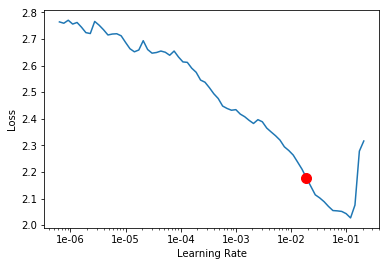

In [18]:
%%time
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [19]:
learn.fit_one_cycle(4,max_lr = 5e-3)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.803725,0.609977,0.609976,2:32:17
1,0.608607,0.396634,0.396634,2:34:18
2,0.529345,0.377475,0.377474,2:34:55
3,0.489597,0.334404,0.334404,2:36:40


In [23]:
learn.save('mdl-frozen')

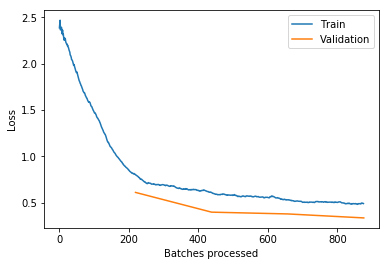

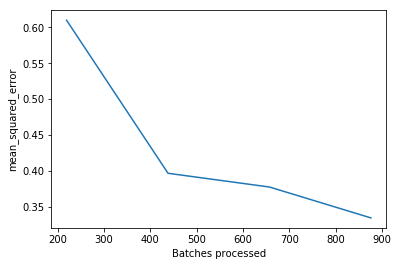

In [20]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
%%time
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))


In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.save('mdl')

# thresholding

In [24]:
%%time
preds_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 6min 3s, sys: 1min 5s, total: 7min 8s
Wall time: 5min 36s


In [25]:
preds_val = preds_val.numpy().squeeze()

In [26]:
y_val= y_val.numpy()

In [27]:
np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

In [28]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [29]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [30]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [31]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [32]:
%%time
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 13.5 s, sys: 6.02 ms, total: 13.5 s
Wall time: 13.5 s


In [33]:
%%time
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 1.4 s, sys: 5.94 ms, total: 1.4 s
Wall time: 1.4 s


In [34]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0000660342883434,
  1.500798712942616,
  2.466868717080064,
  3.1738628240467754],
 'abhishek': array([0.511212, 1.500644, 2.501478, 3.502494])}

In [35]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}

In [36]:
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [37]:
optnm2qwk

{'simple': 0.8825697451371907,
 'hocop1': 0.8774745003336405,
 'abhishek': 0.8834248038634067}

In [38]:
Counter(y_val).most_common()

[(0.0, 930), (2.0, 540), (1.0, 195), (4.0, 157), (3.0, 106)]

In [39]:
optnm2preds_val_grd['abhishek'].squeeze().mean()

1.1281120331950207

In [40]:
Counter(optnm2preds_val_grd['abhishek'].squeeze()).most_common()

[(0.0, 908), (2.0, 570), (3.0, 273), (1.0, 164), (4.0, 13)]

In [41]:
list(zip(optnm2preds_val_grd['abhishek'], y_val))[:10]

[(2.0, 2.0),
 (3.0, 4.0),
 (0.0, 0.0),
 (2.0, 2.0),
 (2.0, 2.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (2.0, 3.0),
 (1.0, 1.0),
 (1.0, 2.0)]

In [42]:
(optnm2preds_val_grd['abhishek'].squeeze()== y_val.squeeze()).mean()

0.7572614107883817

In [43]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

# testing

This goes to Kernel!!

In [44]:
PRFX = 'DevCv070116'

## setup

In [45]:
from fastai import *
from fastai.vision import *
import pandas as pd


In [46]:
p_o = f'../output/{PRFX}'

## preprocess

In [47]:
img2grd = []

In [48]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [49]:
img2grd = np.array(img2grd)

In [50]:
if np.all([Path(o[0]).exists() for o in img2grd]): print('All files are here!')

All files are here!


In [51]:
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, len_blnd_test, replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

## dataset

In [52]:
tfms = get_transforms(do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,
                      max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') #get dataset from dataset
            .split_from_df(col='is_val') #Splitting the dataset
            .label_from_df(cols='target',  label_cls=FloatList) #obtain labels from the level column
          )

    data= (src.transform(tfms,size=sz,
                         resize_method=ResizeMethod.SQUISH,
                         padding_mode='zeros') #Data augmentation
            .databunch(bs=bs,num_workers=0) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

In [53]:
bs = 128 #smaller batch size is better for training, but may take longer
sz = 224
data = get_data(sz, bs)

## model

In [54]:
learn = cnn_learner(data, base_arch=models.resnet50, 
                    metrics = [mse], path=p_o)
learn.loss = MSELossFlat
learn = learn.load('mdl')

In [55]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [56]:
learn.data.add_test(ImageList.from_df(sample_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images',
                                      suffix='.png'))

In [57]:
%%time
# Predictions for test set
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 2min 35s, sys: 11.5 s, total: 2min 46s
Wall time: 1min 54s


In [69]:
%%time
# Predictions for test set
preds_tst, _ = learn.TTA(ds_type=DatasetType.Test)

CPU times: user 24min 36s, sys: 1min 42s, total: 26min 18s
Wall time: 17min 16s


In [83]:
preds_tst =  preds_tst.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [84]:
preds_tst.shape

(1928, 1)

In [85]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [86]:
optnm2qwk = pickle.load(open(f'{p_o}/optnm2qwk.p','rb'))
optnm2coefs = pickle.load(open(f'{p_o}/optnm2coefs.p','rb'))

In [87]:
optnm2qwk, optnm2coefs

({'simple': 0.8825697451371907,
  'hocop1': 0.8774745003336405,
  'abhishek': 0.8834248038634067},
 {'simple': [0.5, 1.5, 2.5, 3.5],
  'hocop1': [1.0000660342883434,
   1.500798712942616,
   2.466868717080064,
   3.1738628240467754],
  'abhishek': array([0.511212, 1.500644, 2.501478, 3.502494])})

In [88]:
coef = optnm2coefs['abhishek']
preds_tst_grd = bucket(preds_tst, coef)

In [89]:
preds_tst_grd.squeeze()

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

In [90]:
Counter(preds_tst_grd.squeeze()).most_common()

[(0.0, 1928)]

## submit

In [91]:
sample = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
sample.diagnosis = preds_tst_grd.squeeze().astype(int)
sample.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [92]:
sample_df.diagnosis.value_counts()

0    1928
Name: diagnosis, dtype: int64

In [93]:
sample.to_csv(f"{p_o}/submission.csv", index=False)